In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import kagglehub
import os
import pathlib
from sklearn.model_selection import train_test_split

c:\Users\luizc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#CARREGANDO E PREPARANDO O DATASET
path = kagglehub.dataset_download("rakibuleceruet/drowsiness-prediction-dataset")
data_dir = pathlib.Path(os.path.join(path, '0 FaceImages'))

active_paths = list(data_dir.glob('Active Subjects/*.jpg'))
active_labels = [0] * len(active_paths) # 0 para 'alerta'
fatigue_paths = list(data_dir.glob('Fatigue Subjects/*.jpg'))
fatigue_labels = [1] * len(fatigue_paths) # 1 para 'fadiga'

all_image_paths = [str(p) for p in (active_paths + fatigue_paths)]
all_labels = active_labels + fatigue_labels

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label

train_dataset = train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(len(train_paths)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = val_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
], name="data_augmentation")

#adicionar lstm (conjunto de 20 frames)

# CARREGA O MODELO DA RESNET50V2
base_model = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # CONGELANDO OS PESOS DO MODELO

# CAMADAS DE CLASSIFICAÇÃO 
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(1, 
                                activation='sigmoid',
                                kernel_regularizer=regularizers.l2(0.001) #adicionando regularização L2
                                )(x)

model_resnet = tf.keras.Model(inputs, outputs) 

otimizador_teste = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) #novo otimizador para teste
otimizador_teste2 = tf.keras.optimizers.Adam(learning_rate=0.0001) #teste

#novas metricas
METRICAS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model_resnet.compile(
    optimizer = otimizador_teste2, # Usando o novo otimizador
    loss = 'binary_crossentropy',
    metrics = METRICAS 
)

#Iniciando o treinamento do modelo de Transfer Learning
history_tl = model_resnet.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset
)

print("\n--- Avaliação Final do Modelo de Transfer Learning ---")
val_loss_tl, val_acc_tl, val_precision_tl, val_recall_tl = model_resnet.evaluate(validation_dataset, verbose=2)

print(f"Acurácia final no conjunto de validação: {val_acc_tl * 100:.2f}%")
print(f"Precisão final no conjunto de validação: {val_precision_tl * 100:.2f}%")
print(f"Recall final no conjunto de validação: {val_recall_tl * 100:.2f}%")

Epoch 1/15


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x00000241697DB740>
Traceback (most recent call last):
  File "c:\Users\luizc\AppData\Local\Programs\Python\Python313\Lib\weakref.py", line 370, in remove
    self = selfref()
KeyboardInterrupt: 


 31/228 ━━━━━━━━━━━━━━━━━━━━ 1:32 468ms/step - accuracy: 0.4765 - loss: 132.3555 - precision: 0.4599 - recall: 0.4885

KeyboardInterrupt: 

In [ ]:
import pickle

MODELS_DIR = "saved_models"
HISTORIES_DIR = "historicos"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(HISTORIES_DIR, exist_ok=True)   

model_tl_path = os.path.join(MODELS_DIR, 'modelo_transfer_learning_resnet.keras')
model_resnet.save(model_tl_path)

loaded_model = tf.keras.models.load_model(model_tl_path)

#EXTRATOR DE CARACTERÍSTICAS

feature_extractor = tf.keras.Model(
    inputs=loaded_model.input,
    outputs=loaded_model.get_layer('global_average_pooling2d_2').output
    )

history_tl_path = os.path.join(HISTORIES_DIR, 'history_transfer_learning_resnet.pkl')

with open(history_tl_path, 'wb') as file:
    pickle.dump(history_tl.history, file)
    
print("modelo e histórico de treinamento salvos")

feature_extractor.summary()

modelo e histórico de treinamento salvos


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

57/57 - 23s - 412ms/step - accuracy: 0.7610 - loss: 4.5995 - precision: 0.6919 - recall: 0.9408

Acurácia de validação final: 0.7609649300575256


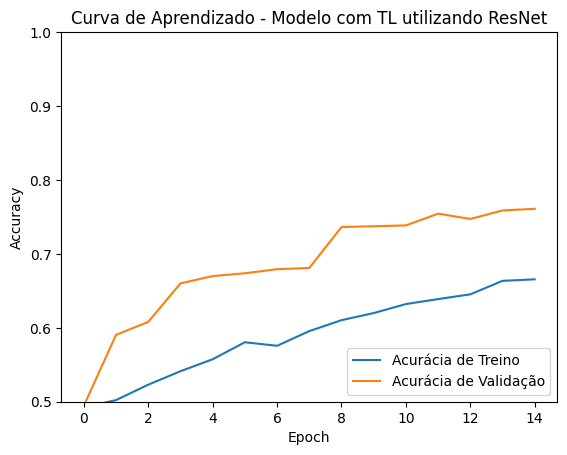

In [14]:
import matplotlib.pyplot as plt
import numpy as np


plt.title("Curva de Aprendizado - Modelo com TL utilizando ResNet"  )
plt.plot(history_tl.history['accuracy'], label='Acurácia de Treino')
plt.plot(history_tl.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

val_loss_tl, val_acc_tl, val_precision_tl, val_recall_tl = model_resnet.evaluate(validation_dataset, verbose=2)

print("\nAcurácia de validação final:", val_acc_tl)